# Analytical Pipeline for LC-MS/MS Metabolomic Studies

## Packages dependencies

MultiABLER is dependent on the following packages:
* [ProteoMM](https://www.bioconductor.org/packages/release/bioc/html/ProteoMM.html)
* [limma](https://www.bioconductor.org/packages/release/bioc/html/limma.html)

We would also use [tidyverse](https://www.tidyverse.org) will be used to manipulate the dataframe and [cowplot](https://wilkelab.org/cowplot/index.html) will be used for plotting the figures.

Guides to install these packages can be found in the package's page.

In [1]:
library(tidyverse)
library(cowplot)
source("MultiableR.r")

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.4     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   2.0.1     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



## Data Preprocessing

LC-MS data preprocessing was performed with [XCMS online](https://xcmsonline.scripps.edu/landing_page.php?pgcontent=mainPage) and [LipidFinder](https://www.lipidmaps.org/resources/tools/lipidfinder/). While XCMS is available via R, we used XCMS online to analyse the LC-MS data to reduce strain on the local server. XCMS is used to perform peak finding and feature alignment. We used the settings that are catered for our vendor on XCMS. The xcms output can be found in `demo_data`.

After data preprocessing with XCMS, LipidFinder was used to normalise the data based on the blank solvent control. Lipidfinder is available both online and as python code. Instruction on installing the python code can be found in [here](https://github.com/ODonnell-Lipidomics/LipidFinder). The `peakfilter` filter module was used to filter the XCMS peaks. Parameters for the module is setup using the `config_params.py` as described in the instruction of LipidFinder. The parameter json file can also be found in `demo_data`.

`run_peakfilter.py -i demo_data/Lx_pos.csv -o LipidFinder_lx_results -p demo_data/param.filter.demo.pos.json`

`run_peakfilter.py -i demo_data/Lx_neg.csv -o LipidFinder_lx_results -p demo_data/param.filter.demo.neg.json`

`run_peakfilter.py -i demo_data/Mx_pos.csv -o LipidFinder_mx_results -p demo_data/param.filter.demo.pos.json`

`run_peakfilter.py -i demo_data/Mx_neg.csv -o LipidFinder_mx_results -p demo_data/param.filter.demo.neg.json`

After the clean up using LipidFinder, the data is imported to MultiABLER for further processing. We use the `read_LipidFindre_csv` function to read the LipidFinder filtered result into MultiABLER. The omic argument is used to tag whether the feature table is lipidomic (Lx) or metabolomic (Mx). The file should be the output from LipidFinder, including a column for "Polarity". The `read_LipidFinder_csv` would read and format the feature table. We can then use the `bind_rows` function from `dplyr` (part of `tidyverse`) to join the four feature tables.

In [2]:
lx_neg <- read_LipidFinder_csv("LipidFinder_lx_results/peakfilter_negative_summary.csv", omic = "Lx")
lx_pos <- read_LipidFinder_csv("LipidFinder_lx_results/peakfilter_positive_summary.csv", omic = "Lx")
mx_neg <- read_LipidFinder_csv("LipidFinder_mx_results/peakfilter_negative_summary.csv", omic = "Mx")
mx_pos <- read_LipidFinder_csv("LipidFinder_mx_results/peakfilter_positive_summary.csv", omic = "Mx")

lipidFinder.data <- bind_rows(lx_neg, lx_pos, mx_neg, mx_pos)
head(lipidFinder.data)

Rows: 2503 Columns: 24

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): Polarity
dbl (23): FeatureID, mzmed, rtmed, L1_mean, L2_mean, L3_mean, L4_mean, L5_me...


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

Rows: 745 Columns: 24

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): Polarity
dbl (23): FeatureID, mzmed, rtmed, L1_mean, L2_mean, L3_mean, L4_mean, L5_me...


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

Rows: 92 Columns: 24

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): Polarity
dbl (23): FeatureID, mzmed, rtmed, L1_mean, L2_mean, L3_mean, L4_mean, L5_me...


ℹ Use `spec()` to retrieve the

Omic,Polarity,FeatureID,mzmed,rtmed,L1,L2,L3,L4,L5,⋯,NL2,NL3,NL4,NL5,NL6,NL7,NL8,NL9,NL10,NL11
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Lx,Negative,LN1658,68.9951,0.4449333,45599,39324,64100,69802,56599,⋯,61986,55862,18689,58154,60147,68719,71172,64177,50321,58844
Lx,Negative,LN2085,71.0128,0.4361083,2333,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,2426
Lx,Negative,LN2089,75.9618,21.4815833,0,0,0,0,0,⋯,0,0,0,0,0,0,2140,0,0,0
Lx,Negative,LN1754,79.9562,0.4468333,27592,7472,6340,8374,9579,⋯,14866,2617,0,0,0,0,0,16074,15572,10266
Lx,Negative,LN2092,88.0394,0.4624500,7466,3103,3441,3602,3694,⋯,5680,2758,0,0,0,0,0,5534,4890,3817
Lx,Negative,LN1604,89.0237,0.4462833,37730,21785,24210,27492,22202,⋯,29392,11839,15137,18547,24784,17708,18412,43381,30924,24724


In [3]:
theme_update(title = element_text(size = 20), 
             axis.text = element_text(size = 15), 
             legend.text = element_text(size = 15),
            strip.text = element_text(size = 15))

## Analytical Pipeline in MultiABLER

After the data is imported, we can first extract the feature table from the additional information. We will then use the `tbManipulate` function of `MultiABLER` to filter, impute and transform the feature table. We will also read in the sample information provided in `demo_data`.

In [4]:
lipidFinder.data <- lipidFinder.data %>% na_if(0)
feature.info <- lipidFinder.data %>% select(Omic, Polarity, FeatureID, mzmed, rtmed)
feature.df <- lipidFinder.data %>% select(-mzmed, -rtmed)
sample.info <- read_csv("demo_data/sample.info.csv")

head(feature.df)

Rows: 20 Columns: 3

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): sample, Label
dbl (1): Biomass, mg


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



Omic,Polarity,FeatureID,L1,L2,L3,L4,L5,L6,L7,⋯,NL2,NL3,NL4,NL5,NL6,NL7,NL8,NL9,NL10,NL11
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Lx,Negative,LN1658,45599,39324,64100,69802,56599,60378,54744,⋯,61986,55862,18689,58154,60147,68719,71172,64177,50321,58844
Lx,Negative,LN2085,2333,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,2426
Lx,Negative,LN2089,NA,NA,NA,NA,NA,NA,NA,⋯,NA,NA,NA,NA,NA,NA,2140,NA,NA,NA
Lx,Negative,LN1754,27592,7472,6340,8374,9579,30804,19153,⋯,14866,2617,NA,NA,NA,NA,NA,16074,15572,10266
Lx,Negative,LN2092,7466,3103,3441,3602,3694,9832,5566,⋯,5680,2758,NA,NA,NA,NA,NA,5534,4890,3817
Lx,Negative,LN1604,37730,21785,24210,27492,22202,60919,22211,⋯,29392,11839,15137,18547,24784,17708,18412,43381,30924,24724


Data processing in the `tbManipulate` function includes filtering, missing value imputation, and logarithmic transformation.

#### Filtering

The first step in the data preprocessing is feature filtering. There are multiple method for data filtering that are commonly used, such as filtering the features by missing values and by the mean abundance of the features. Here, we use a missing value threshold of 3 to filter the data. We would remove any features that has less than 3 values. While the threshold is an arbitually selected number, we use this threshold to maximise the number of features found in the dataset without affecting the normalisation algorithm. The filter threshold can be set in the argument `filter_threshold`.

#### Missing Value Imputation

For missing value imputation, we use the global minimum method. All missing values are imputed with half of the global minimum. This is to provide a small value to the missing values so that the normalisation algorithm may run without drastically affecting the data shape. Imputation implemented includes using half of the global minimum ("gm2"), and a fifth of the global minimum("gm5"). The argument can be set in the field `impute`.

#### Logarithmic transformation

Finally, we transformed the data with log base 2. Base 2 is used here so that in subsequent differential analysis, a fold change of 1 represents a 2-fold change. The log base can be changed using the argument `log_base`.

We use the `group_by` function and the `group_modify` function in `dplyr` to pre-process all four table at once.

In [5]:
mani.df <- feature.df %>% group_by(Omic, Polarity) %>% group_modify(~tbManipulate(.x, 3))
head(mani.df)

Omic,Polarity,FeatureID,L1,L2,L3,L4,L5,L6,L7,⋯,NL2,NL3,NL4,NL5,NL6,NL7,NL8,NL9,NL10,NL11
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Lx,Negative,LN1658,15.476715,15.26312,15.968037,16.090981,15.78849,15.88174,15.740413,⋯,15.919655,15.76958,14.189902,15.827591,15.876205,16.068421,16.119022,15.969769,15.618873,15.844608
Lx,Negative,LN1754,14.751962,12.86728,12.630267,13.031701,13.22566,14.91083,14.225283,⋯,13.859729,11.35370,9.965784,9.965784,9.965784,9.965784,9.965784,13.972441,13.926667,13.325587
Lx,Negative,LN2092,12.866120,11.59945,11.748612,11.814582,11.85097,13.26327,12.442425,⋯,12.471675,11.42941,9.965784,9.965784,9.965784,9.965784,9.965784,12.434107,12.255619,11.898223
Lx,Negative,LN1604,15.203424,14.41105,14.563315,14.746724,14.43840,15.89460,14.438987,⋯,14.843136,13.53126,13.885792,14.178898,14.597121,14.112114,14.168359,15.404776,14.916439,14.593625
Lx,Negative,LN2051,13.531260,14.82977,13.493855,13.066089,13.53163,13.06945,13.381273,⋯,13.861087,14.91481,14.378024,13.157663,13.512494,13.802516,13.012974,13.307343,14.189593,14.180531
Lx,Negative,LN2094,9.965784,12.45121,9.965784,9.965784,12.70109,14.03789,9.965784,⋯,9.965784,14.65793,15.148238,9.965784,9.965784,14.755044,15.549785,9.965784,9.965784,9.965784


## Data Normalisation

For data normalisation, we used EigenMS, which is implemented by the R package `ProteoMM`. EigenMS is a normalisation algorithm that uses single value decomposition (SVD) to remove systematic bias from LC-MS experimetal runs based on the experimental group of the samples. It is useful for experimental design that includes multiple sample groups, as it normalises the sample across the dataset, while retaining the differences between treatment groups.

To run EigenMS, we would use the `eig_norm1` and `eig_norm2` function in the `ProteoMM` package.

In [6]:
options(repr.plot.width=16, repr.plot.height=8)
set.seed(200)

Warning message in ProteoMM::eig_norm1(m = m_logInts, treatment = sample.treatment, :
“This function uses random namber generator. For reproducibility use
    set.seed(12345) with your choce of parameter”
Data dimentions: 221220

Treatment groups: LLLLLLLLLNLNLNLNLNLNLNLNLNLNLNL

Selecting complete peptides

Got 2+ treatment grps

Computing SVD, estimating Eigentrends...

Number of treatments: 2

Number of complete peptides (and samples) used in SVD

221220

Number of treatment groups (in svd.id): 2

Starting Bootstrap.....

Iteration 50

Iteration 100

Iteration 150

Iteration 200

Iteration 250

Iteration 300

Iteration 350

Iteration 400

Iteration 450

Iteration 500

Number of bias trends automatically detected 4

Preparing to plot...

Unique number of treatment combinations:2

Normalizing...

Processing peptide 100

Processing peptide 200

Processing peptide 300

Processing peptide 400

Processing peptide 500

Processing peptide 600

Processing peptide 700

Processing peptide 800


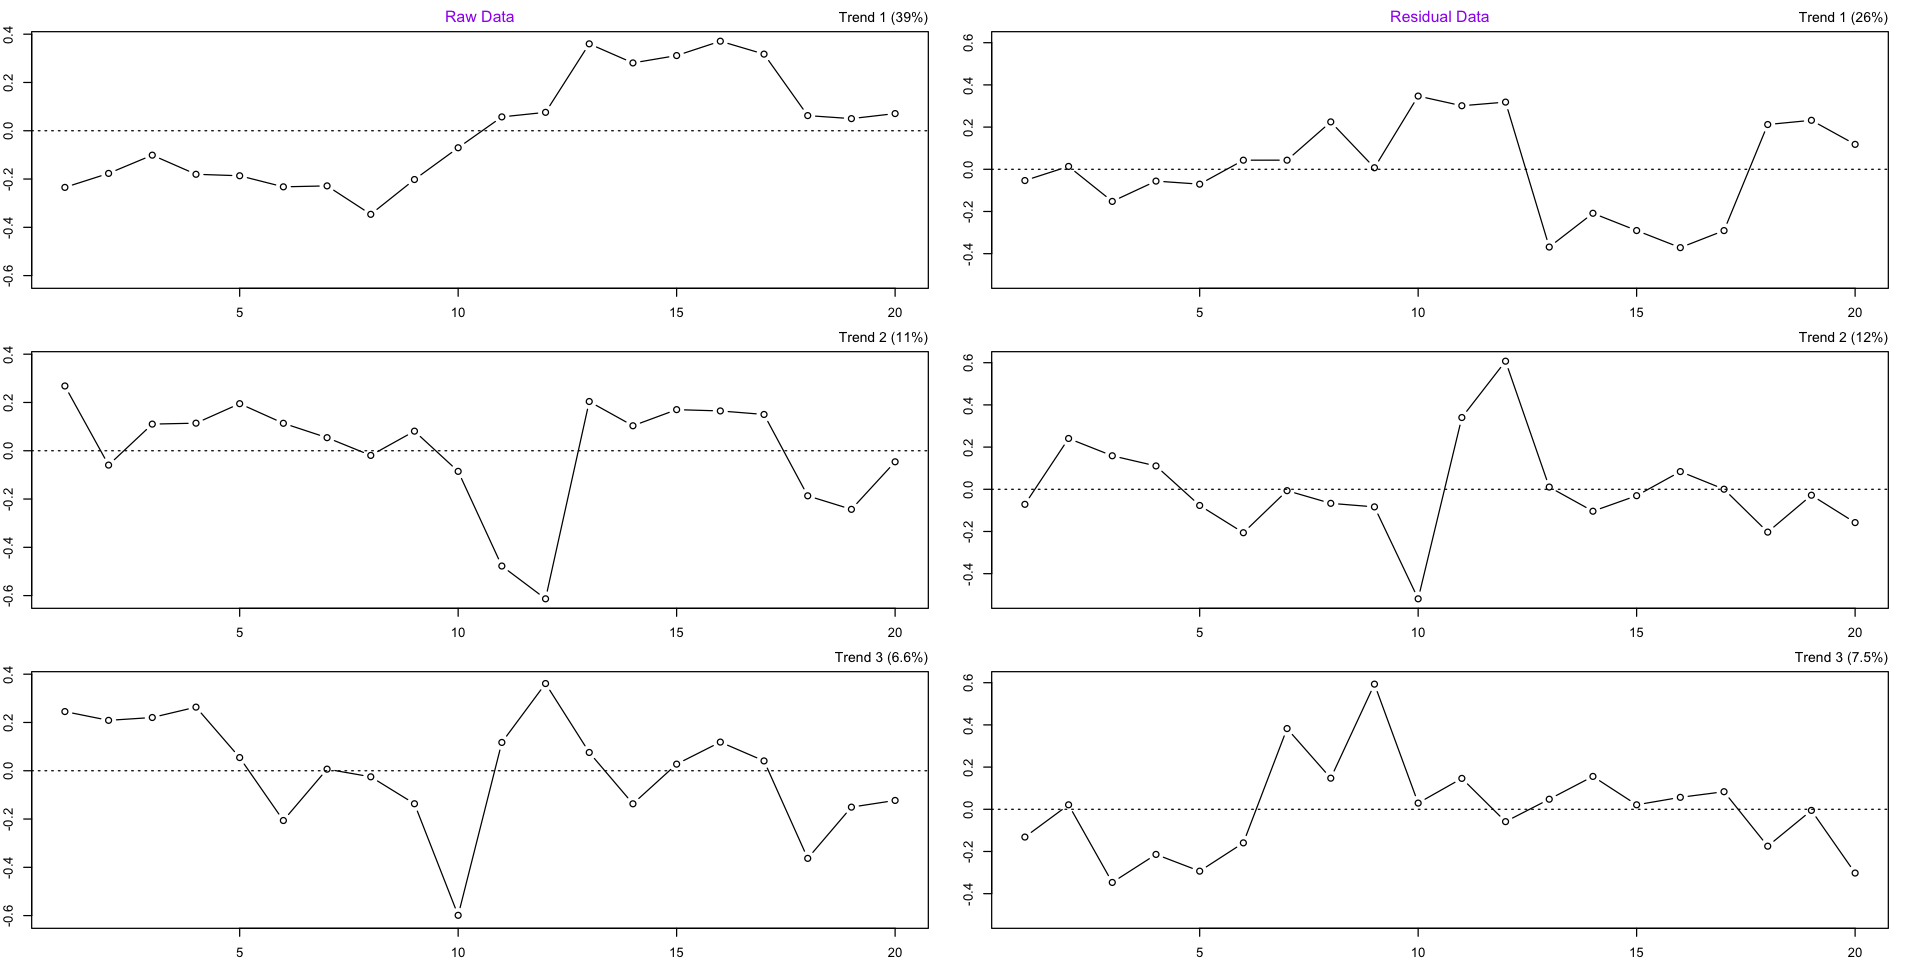

Unique number of treatment combinations:2

Normalizing...

Processing peptide 100

Processing peptide 200

Processing peptide 300

Processing peptide 400

Processing peptide 500

Processing peptide 600



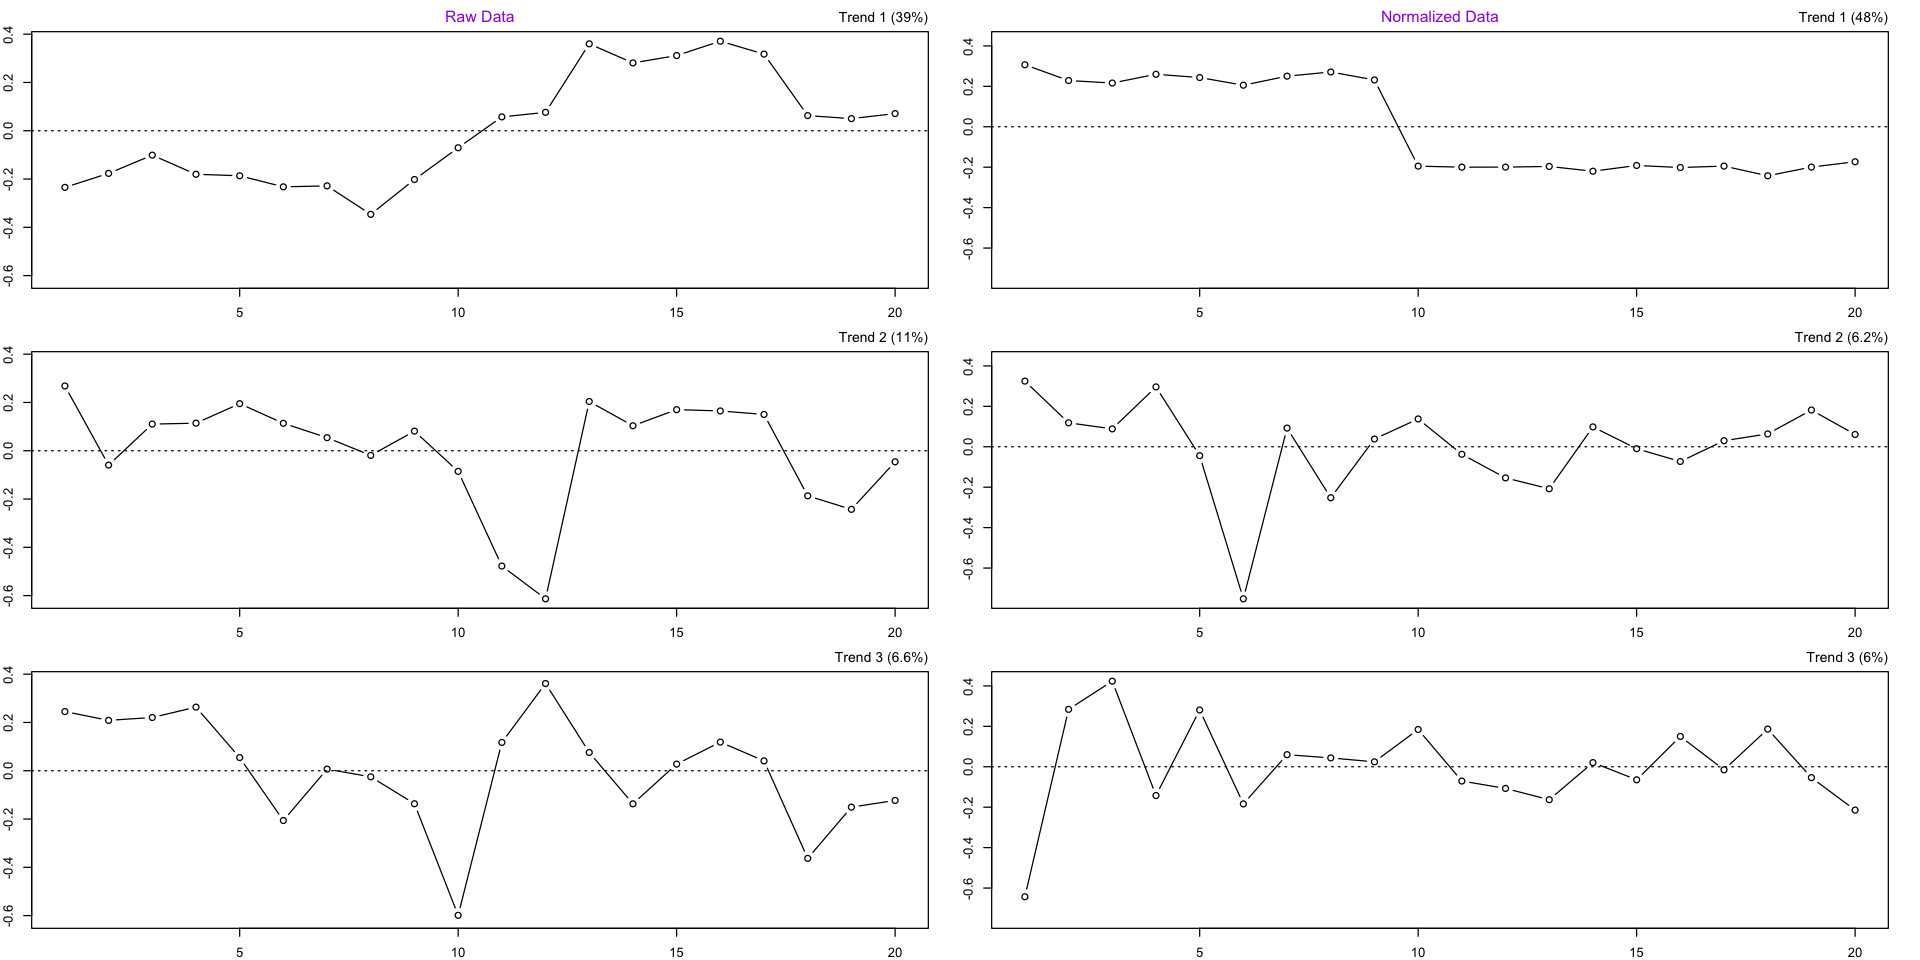

Done with normalization!!!

Warning message in ProteoMM::eig_norm1(m = m_logInts, treatment = sample.treatment, :
“This function uses random namber generator. For reproducibility use
    set.seed(12345) with your choce of parameter”
Data dimentions: 6520

Treatment groups: LLLLLLLLLNLNLNLNLNLNLNLNLNLNLNL

Selecting complete peptides

Got 2+ treatment grps

The following object is masked from TREATS (pos = 3):

    TREATS


The following object is masked from TREATS (pos = 4):

    TREATS


Computing SVD, estimating Eigentrends...

Number of treatments: 2

Number of complete peptides (and samples) used in SVD

6520

Number of treatment groups (in svd.id): 2

Starting Bootstrap.....

Iteration 50

Iteration 100

Iteration 150

Iteration 200

Iteration 250

Iteration 300

Iteration 350

Iteration 400

Iteration 450

Iteration 500

Number of bias trends automatically detected 0

Preparing to plot...



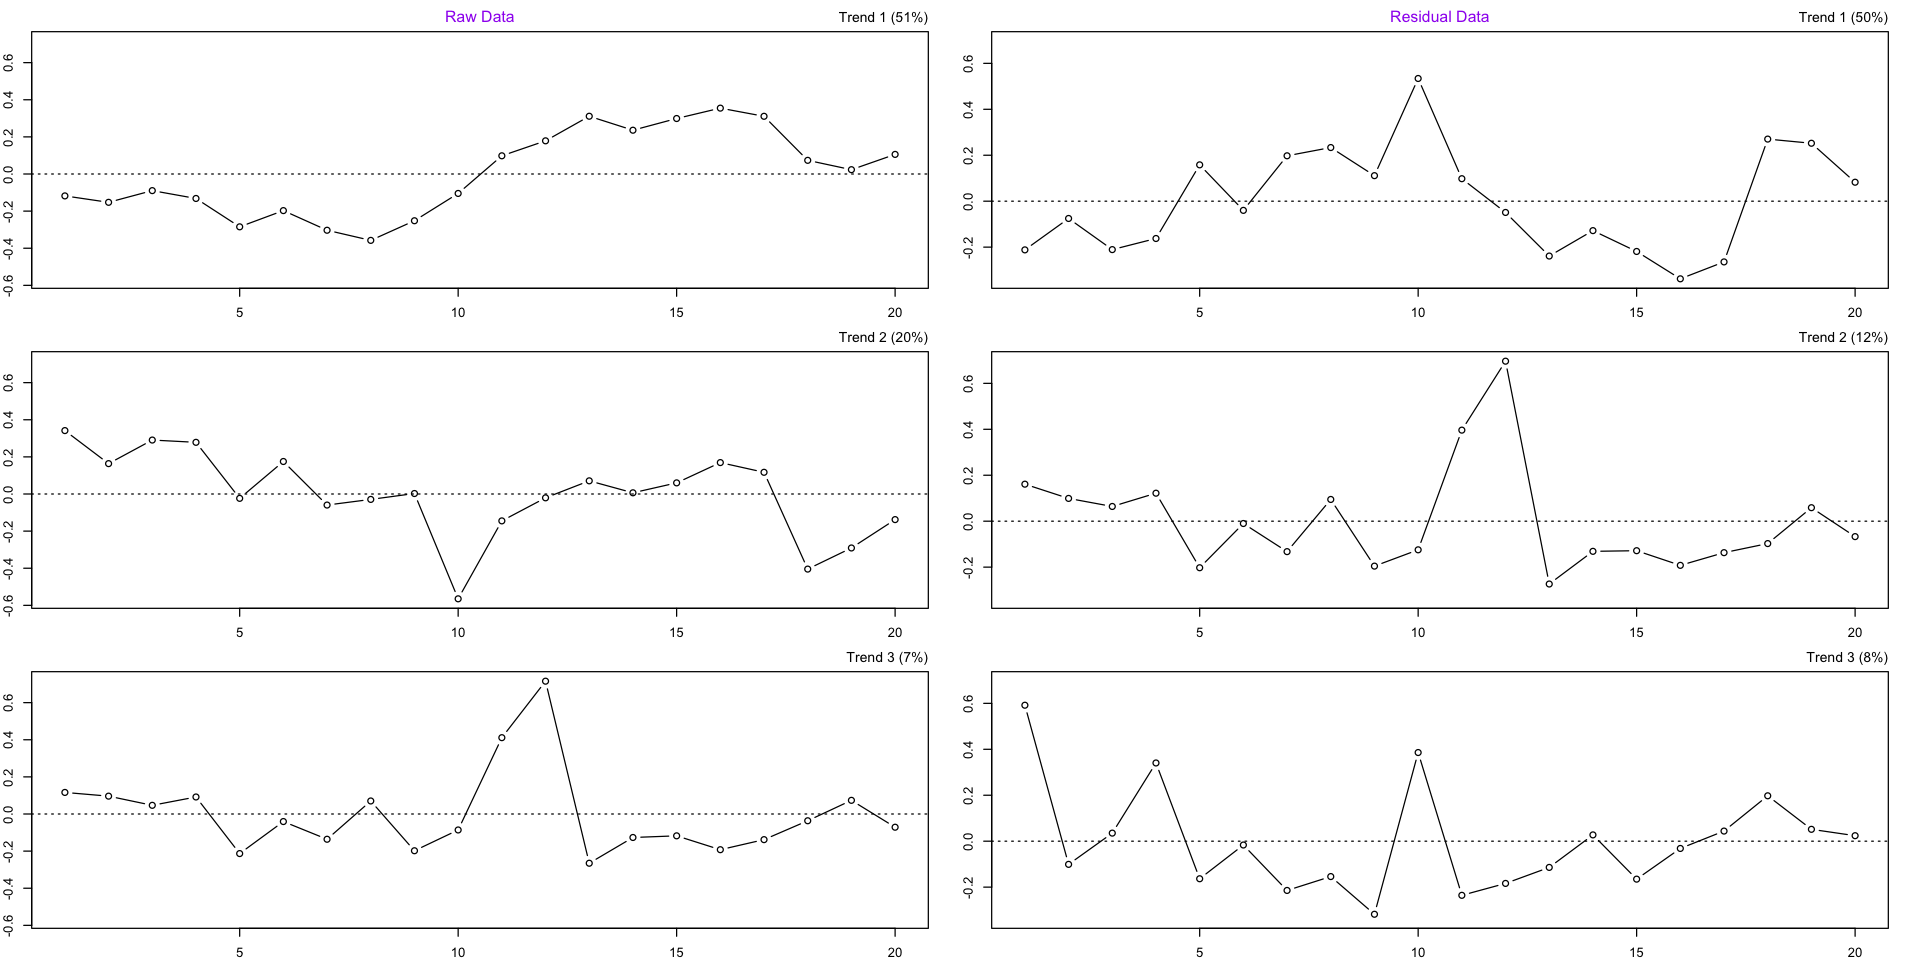


Warning message in ProteoMM::eig_norm1(m = m_logInts, treatment = sample.treatment, :
“This function uses random namber generator. For reproducibility use
    set.seed(12345) with your choce of parameter”
Data dimentions: 9420

Treatment groups: LLLLLLLLLNLNLNLNLNLNLNLNLNLNLNL

Selecting complete peptides

Got 2+ treatment grps

The following object is masked from TREATS (pos = 3):

    TREATS


The following object is masked from TREATS (pos = 4):

    TREATS


The following object is masked from TREATS (pos = 5):

    TREATS


Computing SVD, estimating Eigentrends...

Number of treatments: 2

Number of complete peptides (and samples) used in SVD

9420

Number of treatment groups (in svd.id): 2

Starting Bootstrap.....

Iteration 50

Iteration 100

Iteration 150

Iteration 200

Iteration 250

Iteration 300

Iteration 350

Iteration 400

Iteration 450

Iteration 500

Number of bias trends automatically detected 2

Preparing to plot...



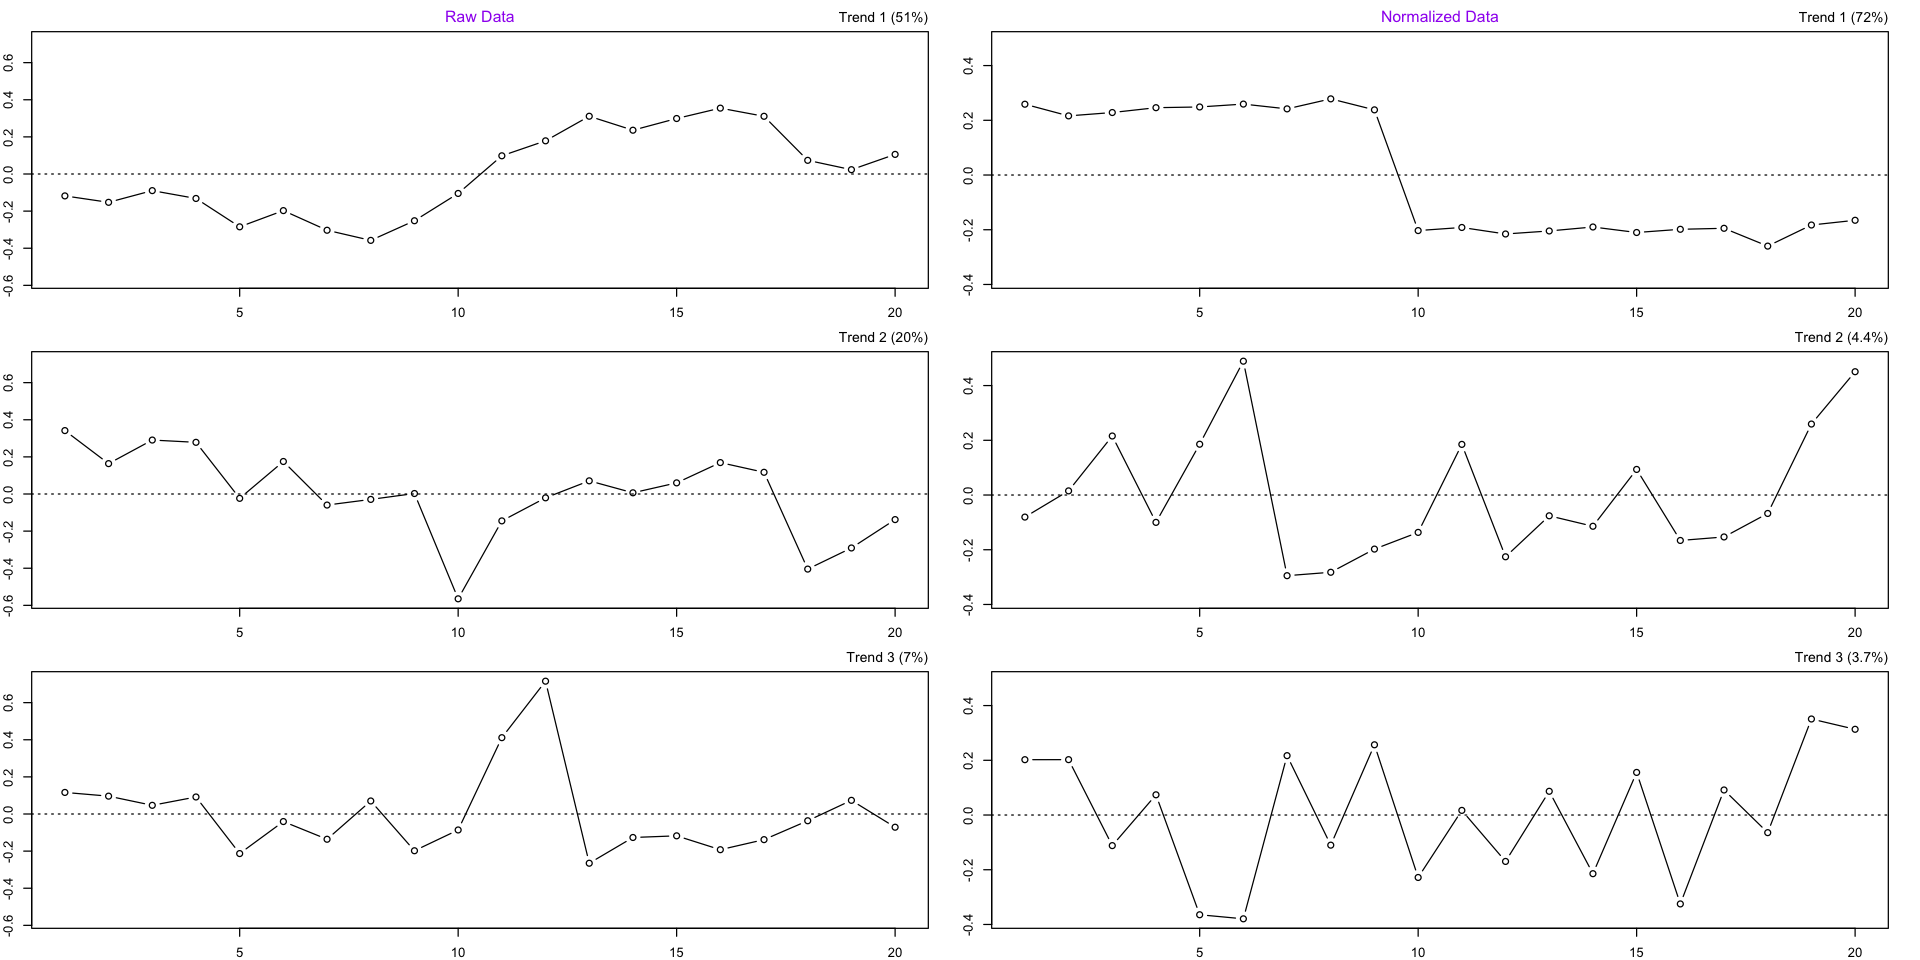

Unique number of treatment combinations:2

Normalizing...



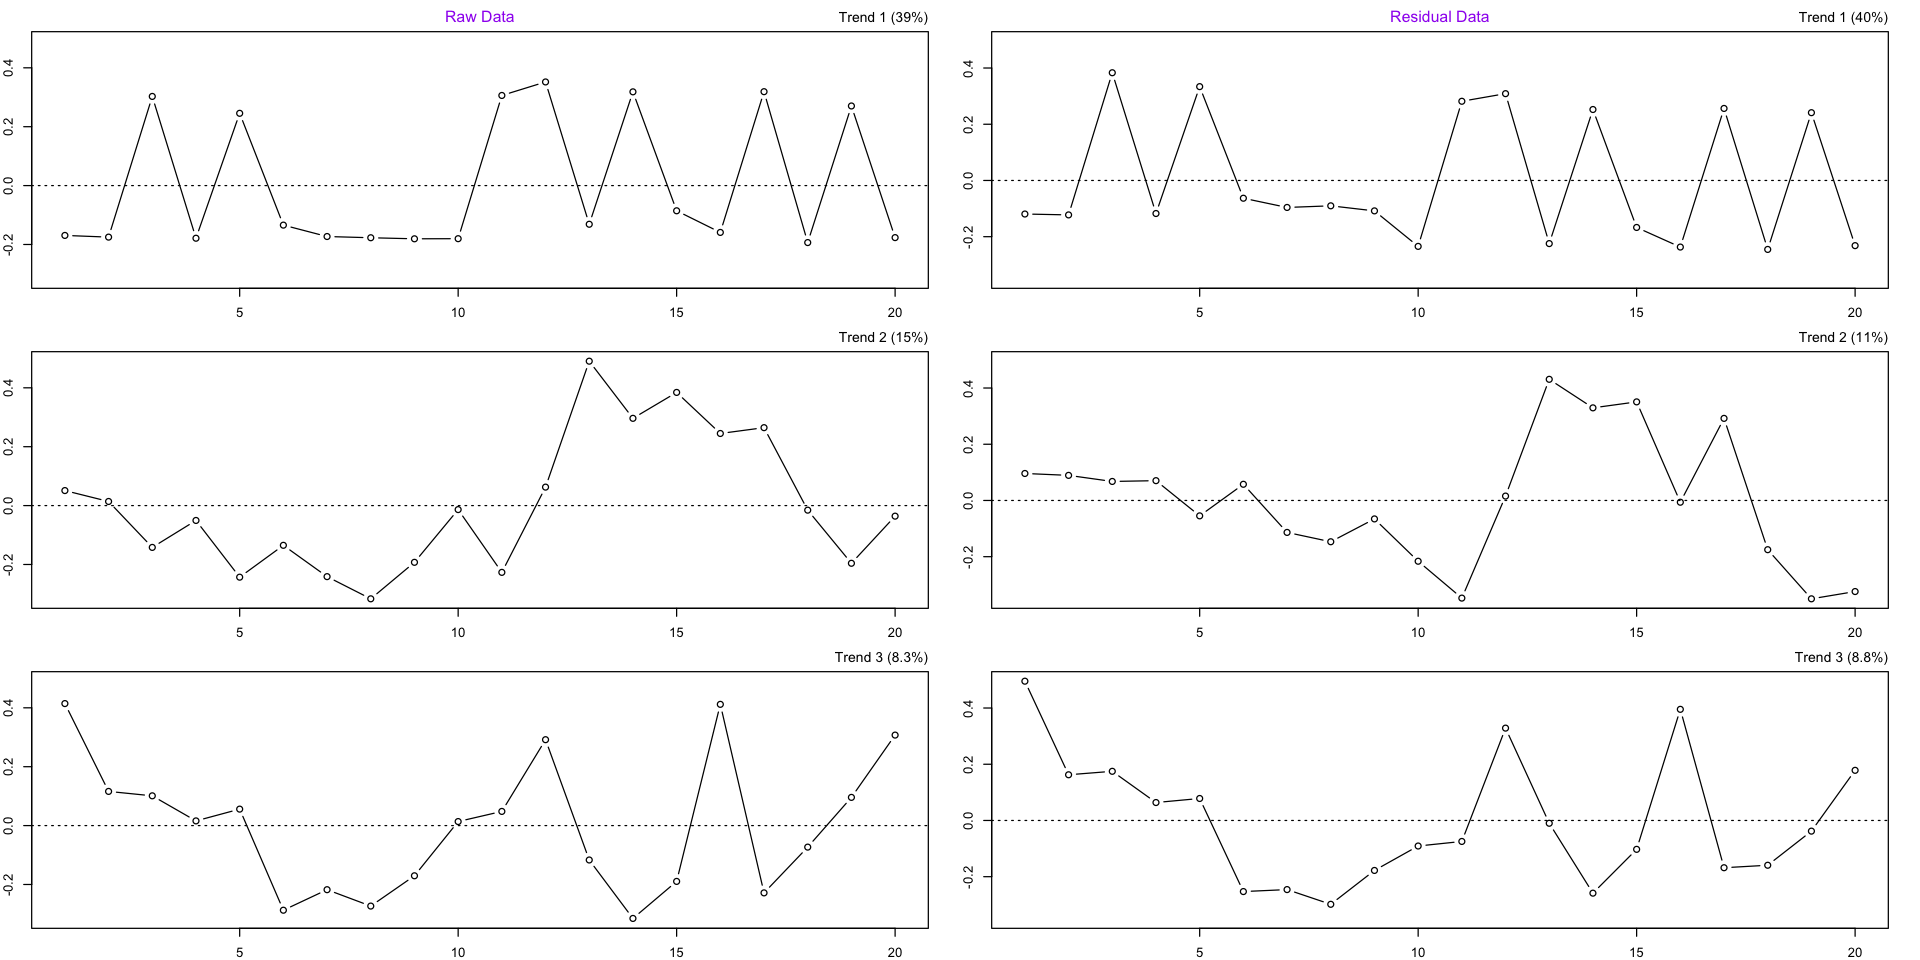

Done with normalization!!!



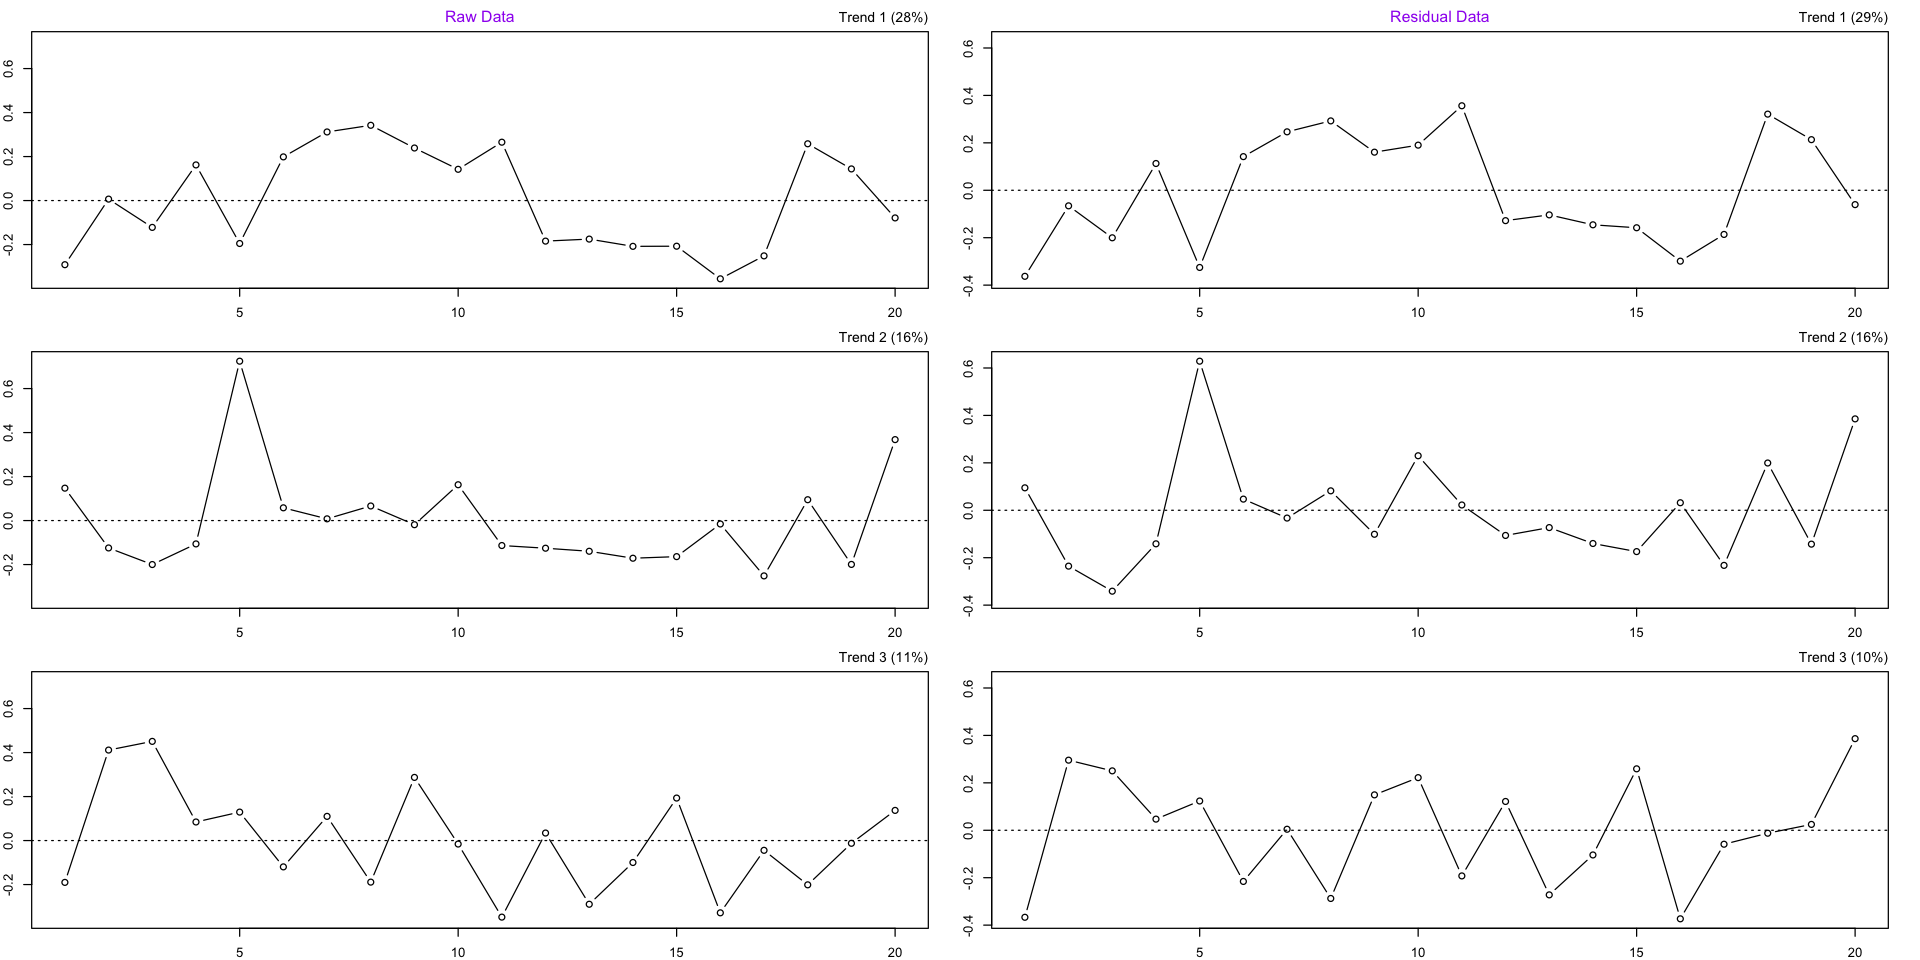

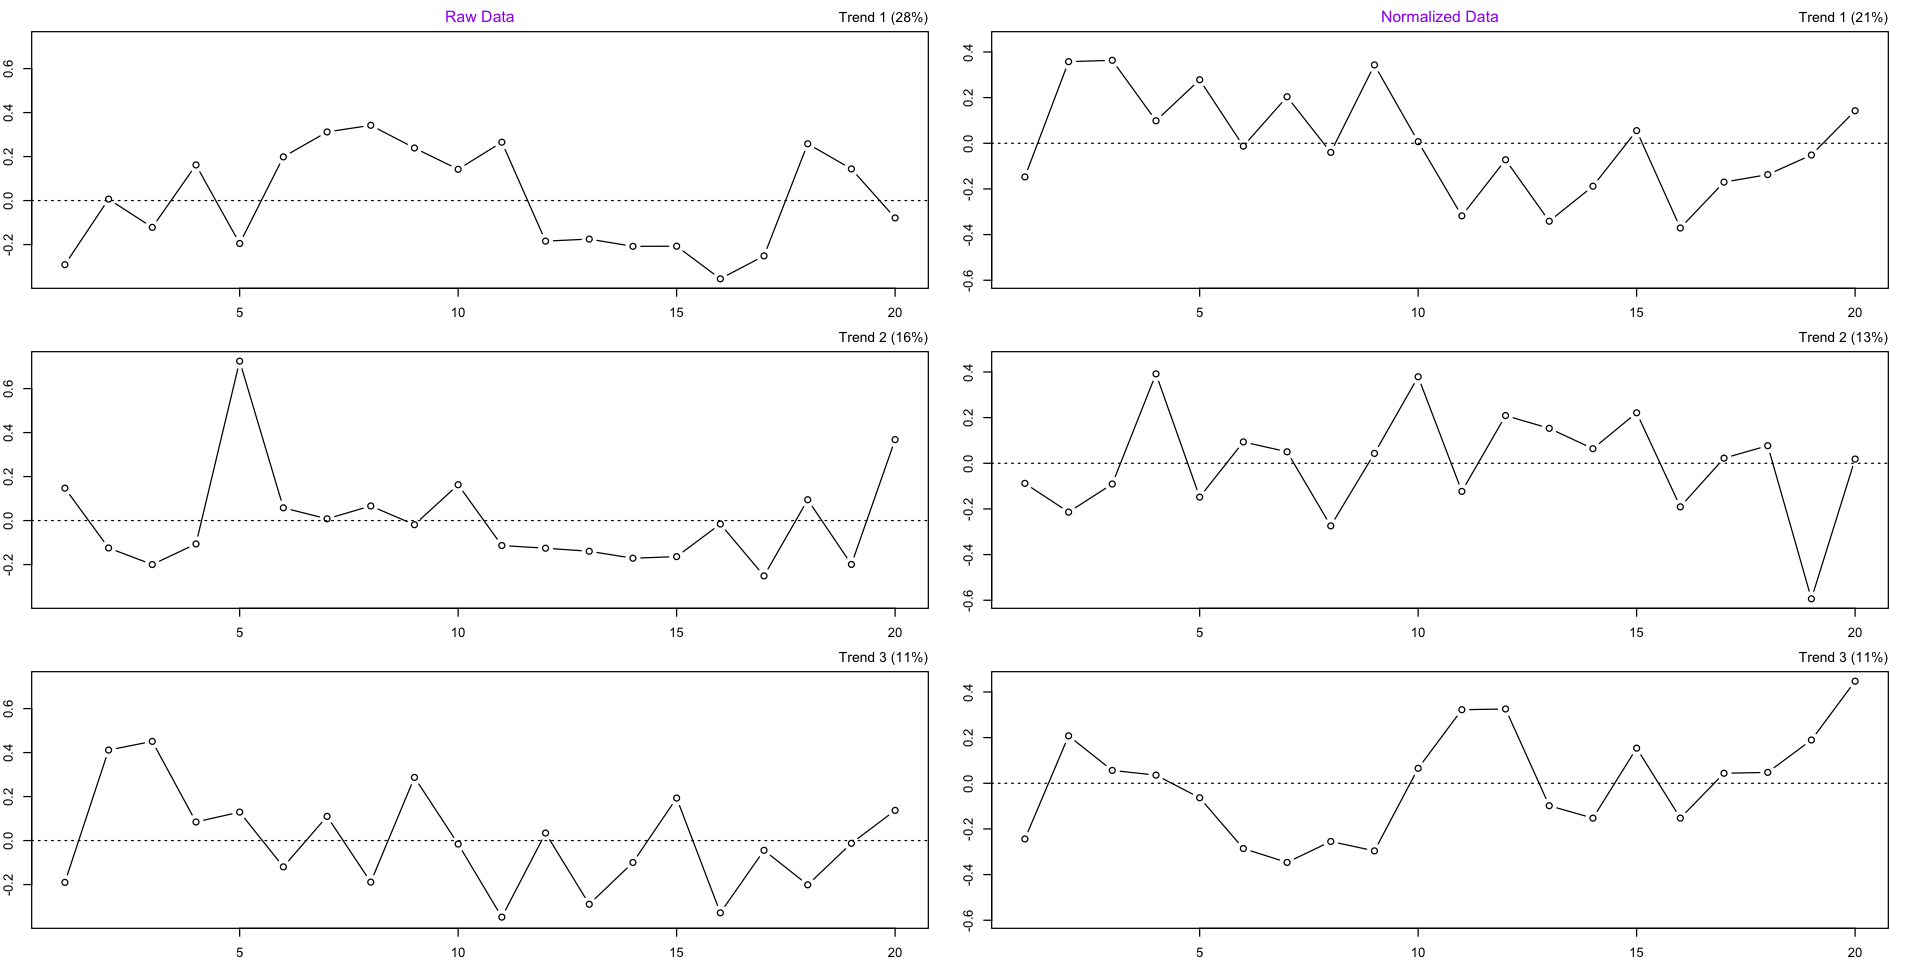

In [7]:
eigenMS.df <- mani.df %>% group_modify(~normEigenMS(.x, rename(sample.info, group = Label)))

We can use the box plot and PCA plot to evaluate the normalisation of the data. After EigenMS normalisation, the sample is normalised across the sample within each tissue group, and PCA result shows that the difference between different tissue group is retained. Noticeably, while EigenMS takes the tissue group into account during normalisation, no extra information regarding the treatment is provided. However, the normalised result shows the plaque data (stable plaque and unstable plaque) are closer to each other than the leison-free data, suggesting the difference between the grouping is real.

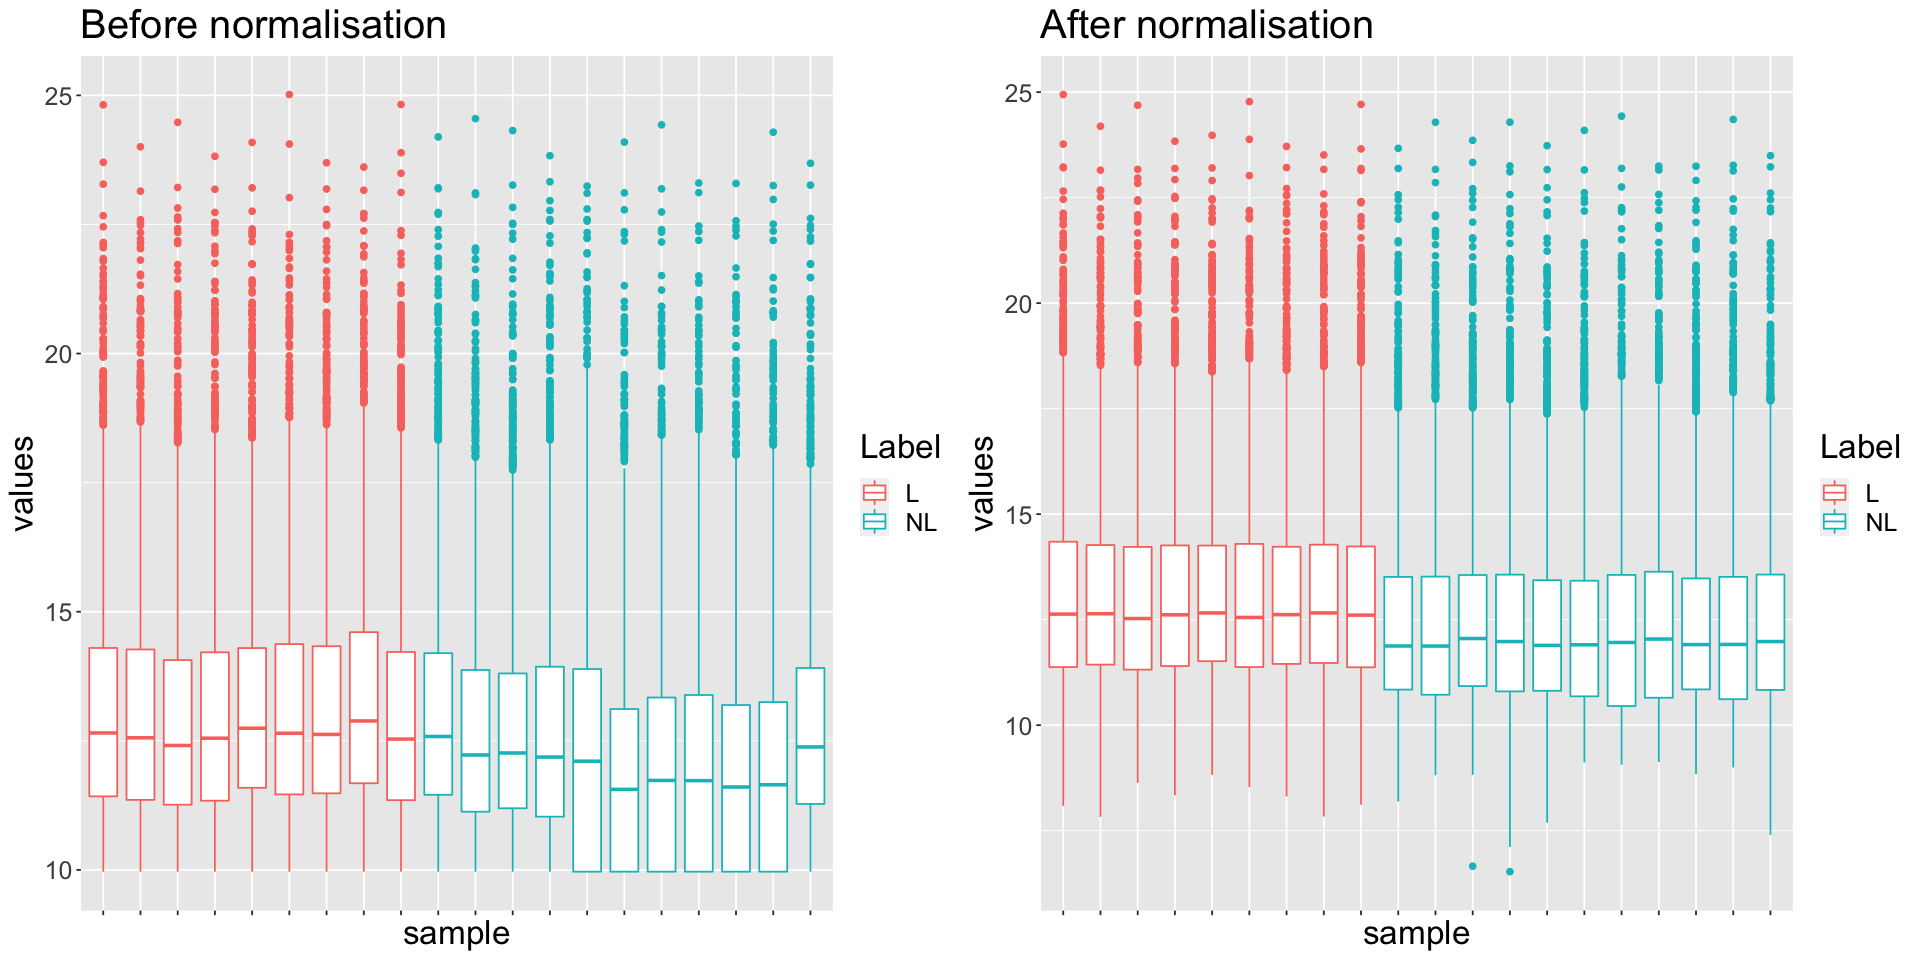

In [8]:
p1 <- stack(mani.df %>% ungroup() %>% select(-Omic, -Polarity, -FeatureID)) %>% inner_join(sample.info, by = c("ind" = "sample")) %>% 
ggplot(aes(x = ind, y = values, color = Label)) + geom_boxplot() +
ggtitle("Before normalisation") + theme(axis.text.x = element_blank()) + xlab("sample")
p2 <- stack(eigenMS.df %>% ungroup() %>% select(-Omic, -Polarity, -FeatureID)) %>% inner_join(sample.info, by = c("ind" = "sample")) %>% 
ggplot(aes(x = ind, y = values, color = Label)) + geom_boxplot() +
ggtitle("After normalisation") + theme(axis.text.x = element_blank()) + xlab("sample")

cowplot::plot_grid(p1, p2, nrow = 1)

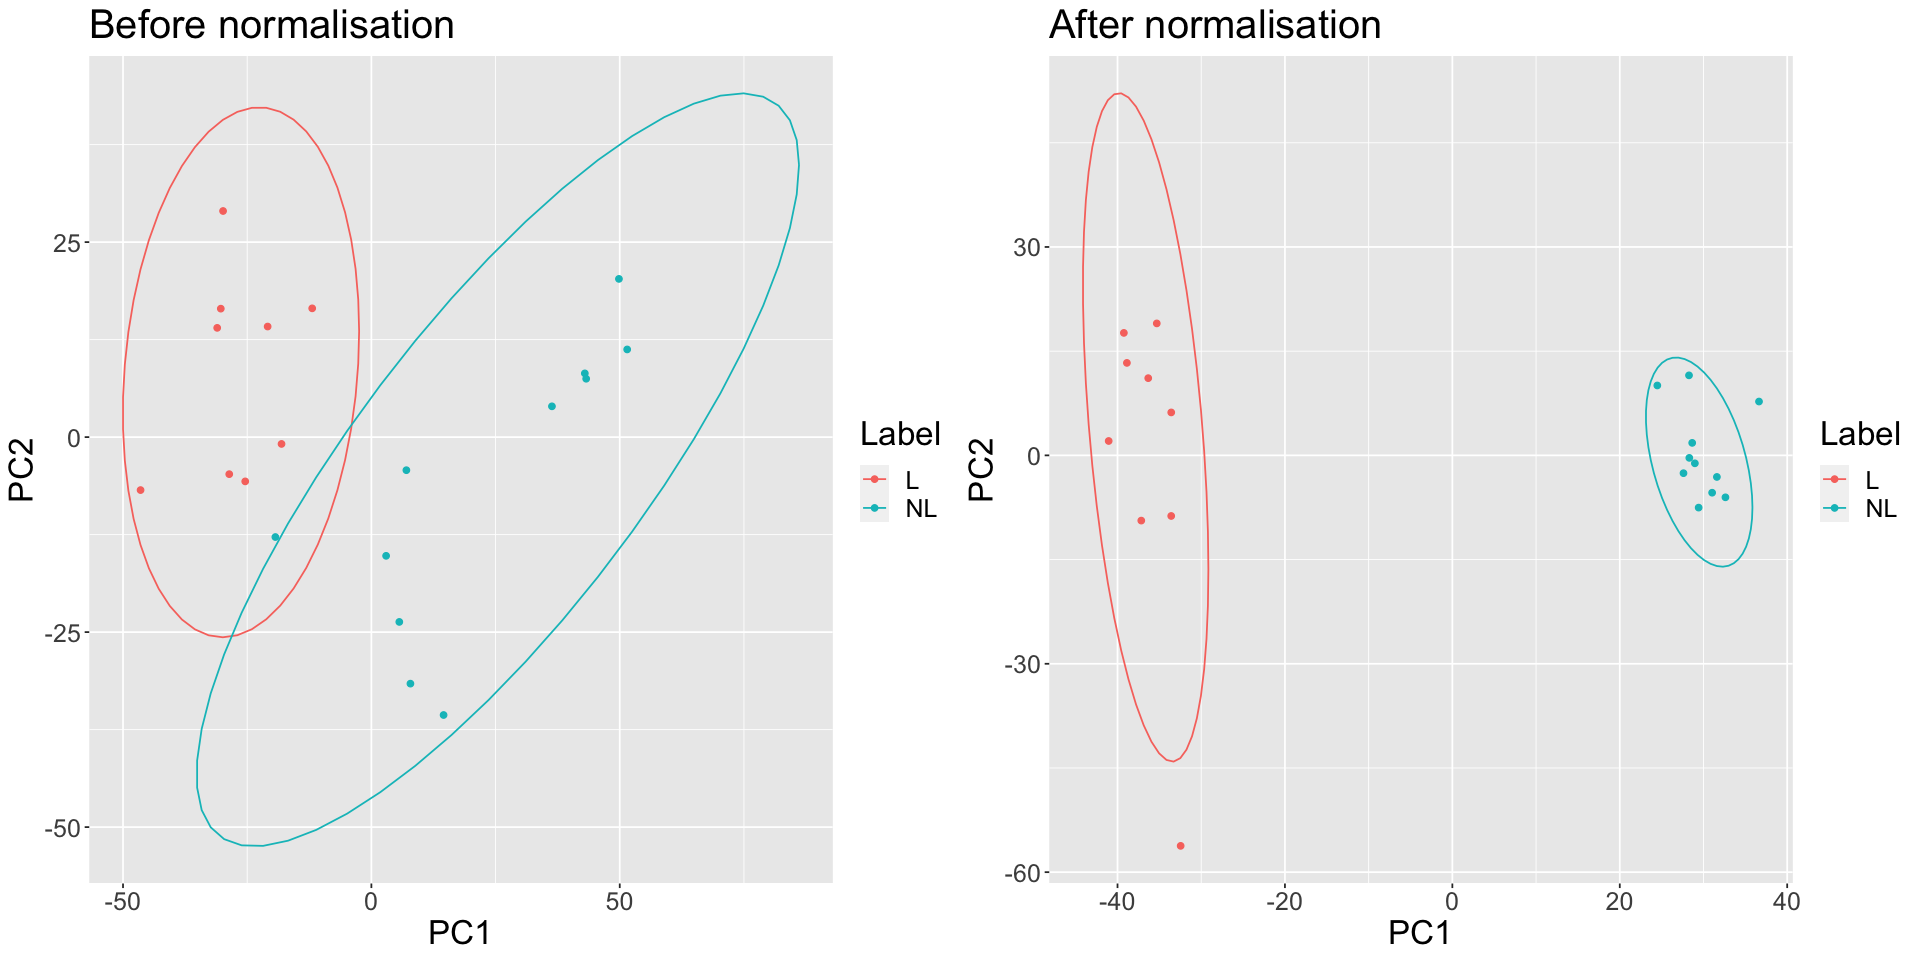

In [9]:
before.norm <- prcomp(t(mani.df %>% ungroup() %>% select(-Omic, -Polarity) %>% column_to_rownames("FeatureID")), scale = TRUE)
after.norm <- prcomp(t(eigenMS.df %>% ungroup() %>% select(-Omic, -Polarity) %>% column_to_rownames("FeatureID")), scale = TRUE)

before.norm.df <- data.frame(before.norm$x)
before.norm.df$sample <- rownames(before.norm.df)

after.norm.df <- data.frame(after.norm$x)
after.norm.df$sample <- rownames(after.norm.df)

p1 <- before.norm.df %>% inner_join(sample.info, by = "sample") %>% ggplot(aes(PC1, PC2, color = Label)) +
geom_point() + stat_ellipse() + ggtitle("Before normalisation")
p2 <- after.norm.df %>% inner_join(sample.info, by = "sample") %>% ggplot(aes(PC1, PC2, color = Label)) +
geom_point() + stat_ellipse() + ggtitle("After normalisation")

cowplot::plot_grid(p1, p2, nrow = 1)

Although EigenMS normalisation normalise the sample within the tissue group, it does not standardise the overall feature table to the same median. Therefore, we further standardise the range of the sample to the same median so that we can compare the value across different samples.

In [10]:
eigenMS.median.df <- eigenMS.df %>% group_modify(~normMedian(.x))
head(eigenMS.median.df)

Omic,Polarity,FeatureID,L1,L2,L3,L4,L5,L6,L7,⋯,NL2,NL3,NL4,NL5,NL6,NL7,NL8,NL9,NL10,NL11
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Lx,Negative,LN1658,14.740869,14.89647,15.34951,15.59269,15.12723,15.47713,15.690142,⋯,16.21457,16.08871,14.57842,16.187608,16.074453,16.09154,16.46071,16.12910,16.22336,16.11642
Lx,Negative,LN1754,14.527007,12.86981,13.71201,13.27092,13.13608,13.98410,13.451722,⋯,13.13423,11.30311,12.37595,11.176702,11.678312,12.43881,11.90139,12.73601,12.93689,12.67602
Lx,Negative,LN2092,12.570982,11.28559,12.18474,11.73846,11.66648,12.70458,11.851973,⋯,11.88788,11.12964,11.59481,10.908413,11.119472,11.49884,11.29465,11.90599,11.83722,11.71693
Lx,Negative,LN1604,14.821495,14.18104,14.68716,14.55020,14.07364,15.41893,13.911532,⋯,15.21505,14.31344,14.46332,14.509696,14.910094,14.68510,14.68181,15.45648,15.07594,14.66260
Lx,Negative,LN2051,13.514898,13.96170,13.15307,12.40882,13.20755,13.02148,13.018731,⋯,13.70302,14.34998,14.79881,13.841018,13.772433,14.37174,13.52957,13.89651,14.20415,14.21601
Lx,Negative,LN2094,9.447787,11.49142,8.94060,9.27967,12.38577,14.47699,9.575591,⋯,10.17606,14.52962,14.31119,9.759598,9.313093,13.39713,14.89979,11.51122,11.32021,11.32971


## Feature Annotation

Feature annotation are typically performed based on the feature table optained from data preprocessor such as XCMS and MS-DIAL. There are many stand-alone metabolomic feature annotation available, however often not compatible with R. Some feature annotation programmes includes OpenMS (Röst et al., 2016), SIRIUS and CSI:FingerID (Rurik et al., 2020). However, while having a stand-alone annotation programme limits the ability of running a workflow on an unified pipeline, this also provides a greater flexibility in analysing the dataset, and matching the annotation programme that is suitable for the dataset. Here, we use [LipidMatch](https://innovativeomics.com/software/lipidmatch-modular-annotates-a-feature-table/) to annotate the lipidomic data. The lipidomic annotation can be found in `demo_data`. However, we are unable to annotate the differentially expressed metabolomic features.

In [11]:
lx.annotation <- read_csv("demo_data/Lx.annotation.csv")

Rows: 64 Columns: 5

── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): FeatureID, lipidMatch, ion
dbl (2): mzmed, rtmed


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



## Statistical analysis

Statistical analysis is performed on the normalised feature table. Here, we presented differential analysis using the `limma` package. However, there are other statistical analysis could be performed, such as network analysis and marker identification, with the annotated normalised feature table.

In [12]:
label <- as.factor(sample.info$Label)
design <- model.matrix(~ label)
colnames(design)[1] <- "Intercept"

cont.matrix <- limma::makeContrasts(NLvL = -labelNL, levels = design)

limma.result <- eigenMS.median.df %>% group_by(Omic, Polarity) %>% group_modify(~runLimma(.x, design.matrix = design, cont.matrix = cont.matrix)) %>% ungroup()
head(limma.result)

Omic,Polarity,FeatureID,logFC.NLvL,adj.P.Val.NLvL
<chr>,<chr>,<chr>,<dbl>,<dbl>
Lx,Negative,LN4102,3.242481,6.044535e-14
Lx,Negative,LN3275,3.281732,6.044535e-14
Lx,Negative,LN1167,2.359491,7.966276e-14
Lx,Negative,LN1389,3.339258,7.966276e-14
Lx,Negative,LN1642,3.892949,1.266037e-13
Lx,Negative,LN1837,4.331490,1.501960e-13


Finally, we can plot the differential analysis result using the output from Limma.

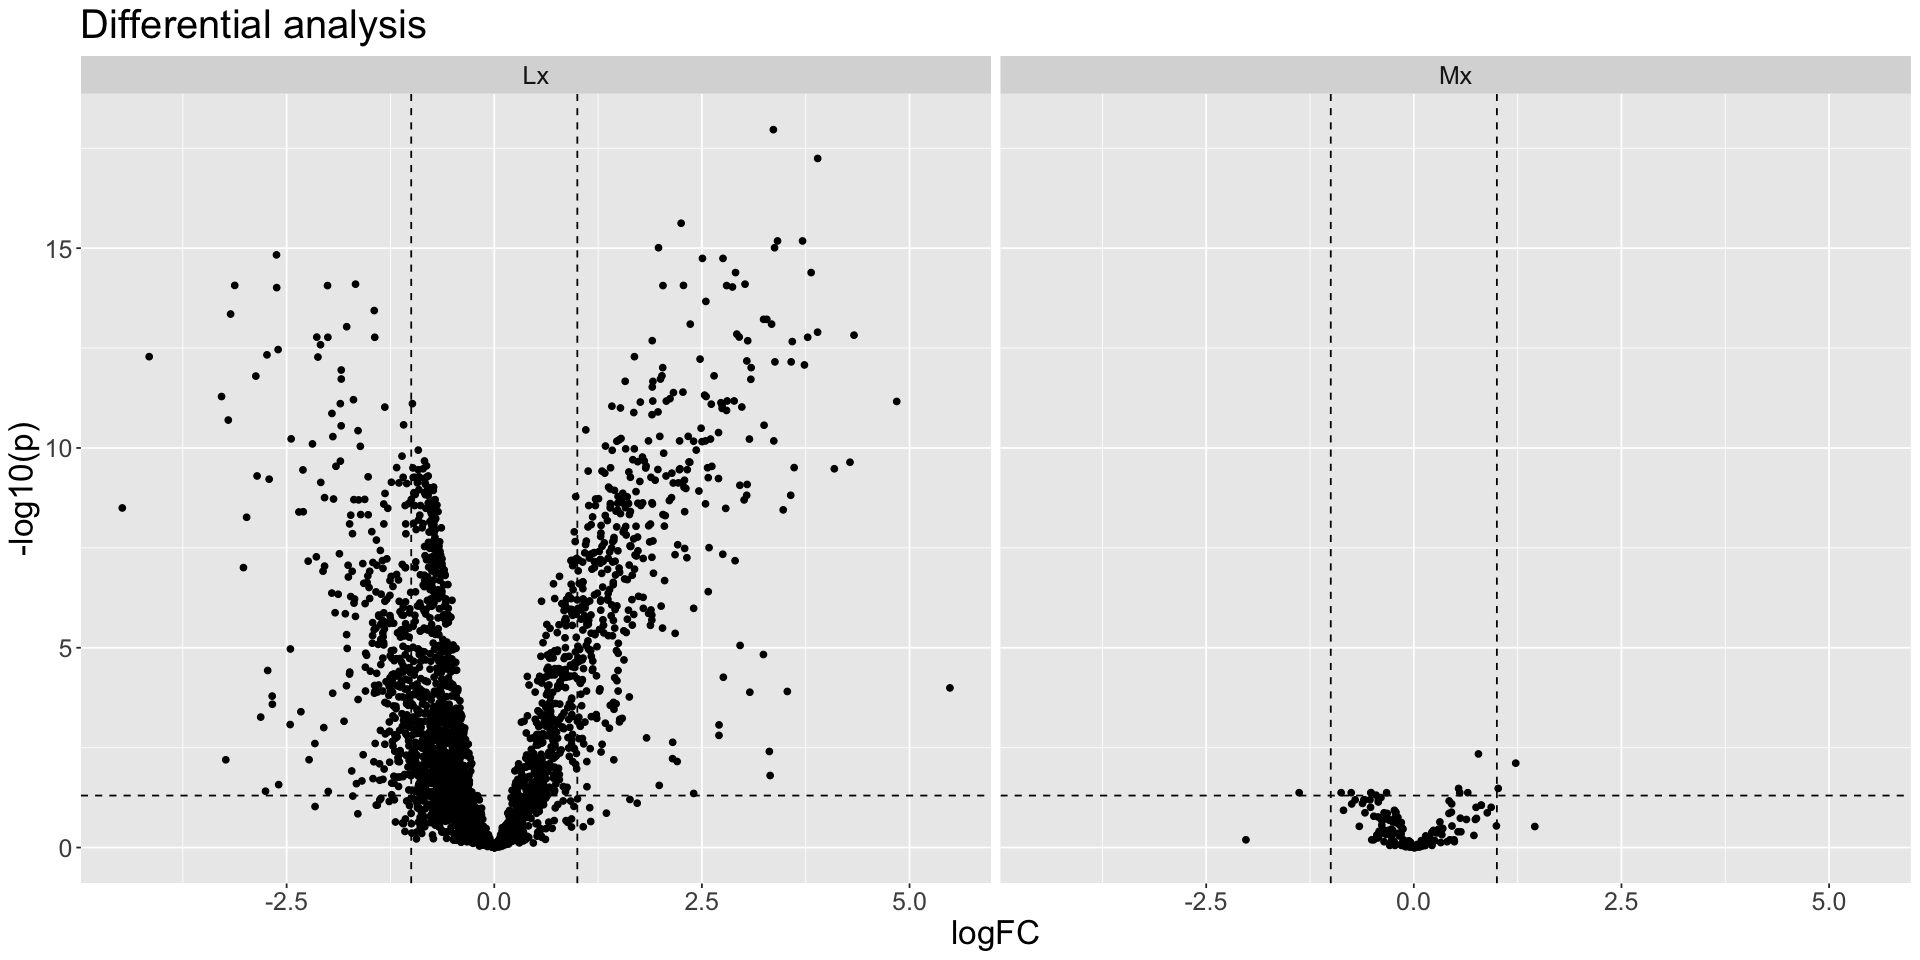

In [13]:
limma.result %>% ggplot(aes(logFC.NLvL, -log10(adj.P.Val.NLvL))) + geom_point() + facet_wrap(~Omic) +
xlab("logFC") + ylab("-log10(p)") + geom_hline(yintercept = -log10(0.05), lty = "dashed") +
geom_vline(xintercept = c(-1,1), lty = "dashed") +
ggtitle("Differential analysis")

## Session Info

In [14]:
sessionInfo()

R version 4.1.0 (2021-05-18)
Platform: x86_64-apple-darwin17.0 (64-bit)
Running under: macOS Big Sur 10.16

Matrix products: default
BLAS:   /Library/Frameworks/R.framework/Versions/4.1/Resources/lib/libRblas.dylib
LAPACK: /Library/Frameworks/R.framework/Versions/4.1/Resources/lib/libRlapack.dylib

locale:
[1] C/UTF-8/C/C/C/C

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] limma_3.48.3    ProteoMM_1.10.0 cowplot_1.1.1   forcats_0.5.1  
 [5] stringr_1.4.0   dplyr_1.0.7     purrr_0.3.4     readr_2.0.1    
 [9] tidyr_1.1.3     tibble_3.1.4    ggplot2_3.3.5   tidyverse_1.3.1

loaded via a namespace (and not attached):
 [1] ggrepel_0.9.1      Rcpp_1.0.7         lubridate_1.7.10   assertthat_0.2.1  
 [5] digest_0.6.27      utf8_1.2.2         IRdisplay_1.1      R6_2.5.1          
 [9] cellranger_1.1.0   repr_1.1.4         backports_1.2.1    reprex_2.0.1      
[13] evaluate_0.14      httr_1.4.2         pillar_1.6